# Extended hybrid training

Ok, so while I'm waiting for the extended hybrid from Francesco, I wanted to make a few intiution plots to see if I would expect this new hybrid training sample to be helping me or not.

- Evolution of $n_{trks}^{HF}$ and $n_{trks}^{frag}$ as a function of jet $p_T$
- The performance of a model trained on a dedicated extended Z' sample c.f. a model trained on the standard hybrid sample


In [1]:
import numpy as np
import h5py
import sys
import pandas as pd
import xarray as xr

sys.path.append("../..")
from usefulFcts import *
from trainNet import *
from plottingFcts import *

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


**Open a dataset**

In [2]:
subDir = 'mc16d_PFlow_Zprime_5TeV'
dataDir = '../../data/'+subDir
vStr = "sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits"
dataTagTest = "2mtest_15trks_{}_sd0_rev_hybrid_1.5TeV_scale".format(vStr)

f_name = "{}/data_{}.hdf5".format(dataDir,dataTagTest)

f = h5py.File(f_name,"r")
    
X = f['X_test'][:]
y = f['y_test'][:]
ix = f['ix_test'][:]

f.close()

In [3]:
Ntest, nFeatures, nTrks = X.shape

In [4]:
df_tag = '2mtest_15trks_sd0_rev'

jet_df = pd.read_hdf('{}/jet_{}.h5'.format(dataDir,df_tag), key='jet_df')
trk_xr = xr.open_dataarray('{}/trk_{}.nc'.format(dataDir,df_tag))

In [5]:
jet_df.columns

Index(['LabDr_HadF', 'pt_orig', 'eta_orig', 'phi_orig', 'm', 'ip3d_llr',
       'ip3d_pb', 'ip3d_pc', 'ip3d_pu', 'aliveAfterOR', 'aliveAfterORmu',
       'JVT', 'pt', 'eta', 'rnnip_pu', 'rnnip_pc', 'rnnip_pb', 'rnnip_ptau',
       'avgmu', 'eventnb'],
      dtype='object')

In [6]:
trk_xr['var']

<xarray.DataArray 'var' (var: 25)>
array(['sd0', 'sz0', 'ip3d_d0', 'ip3d_z0', 'ip3d_grade', 'pt', 'eta', 'theta',
       'phi', 'orig', 'nInnHits', 'nsharedBLHits', 'nsplitBLHits',
       'nNextToInnHits', 'nPixHits', 'nPixHoles', 'nsharedPixHits',
       'nsplitPixHits', 'nSCTHits', 'nSCTHoles', 'nsharedSCTHits', 'ptfrac',
       'dr', 'prbP', 'pPerp'], dtype=object)
Coordinates:
  * var      (var) object 'sd0' 'sz0' 'ip3d_d0' ... 'dr' 'prbP' 'pPerp'

*Good news!* Since `orig` is inside the trk_xr, I should be able to get this plot that I wanted :)

**Plan:** Add new columns to the df for the # of tracks for each of the categories, although I think I'm going to make this plot just focusing on the HF and fragmentation tracks.

In [7]:
trk_origs = trk_xr.loc[:,:,'orig'].values

In [8]:
for o, orig_tag, trk_label in zip([(0,1), 2, -1, 3], ['HF','frag','PU','GEANT'],
                                  ['heavy flavor', "fragmentation", "pile-up", "GEANT"]):

    if type(o) == tuple:
        orig_mask = np.zeros(15, dtype=np.bool)
        for oi in o:
            orig_mask = orig_mask | (trk_origs == oi)

        # For this jet, I can't just *add* up the origin mask, b/c the b-jets have 
        # this variable assigned as the mask values
        trkExists = (np.sum(X, axis=-1) != 0)

        orig_mask = orig_mask & trkExists

    else:
        orig_mask = (trk_origs == o)

    key = 'ntrk_' + orig_tag
    jet_df[key] = np.sum(orig_mask, axis=-1)

In [9]:
orig_mask.shape

(1500000, 15)

In [10]:
trk_origs.shape

(1500000, 15)

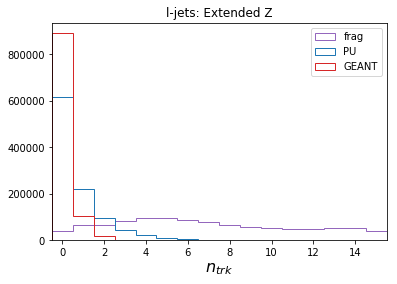

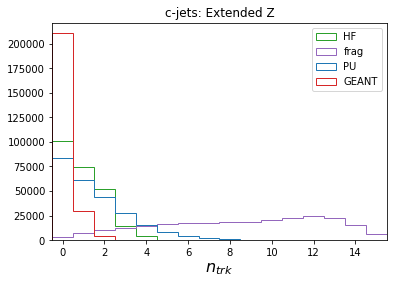

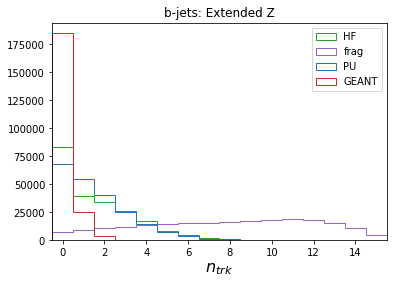

In [9]:
figDir = '../../figures'

nBins = 16
myRange = (-0.5,15.5)

for pdg,flav in zip([0,4,5],['l','c','b']):

    plt.figure()
    
    for orig_tag, c in zip(['HF','frag','PU','GEANT'],['C2','C4','C0','C3']):

        if (pdg == 0) and (orig_tag == 'HF'):
            continue
        
        key = 'ntrk_'+orig_tag
        plt.hist(jet_df.loc[jet_df.LabDr_HadF == pdg,key], bins=nBins, range=myRange,
                 label=orig_tag, color=c, histtype='step')

    plt.xlim(myRange)
    plt.xlabel('$n_{trk}$',fontsize=16)
    plt.legend()
    plt.title(flav+'-jets: Extended Z')
    
    plt.savefig('{}/mc16d_PFlow_Zprime_5TeV/{}-jets_nTrks.pdf'.format(figDir,flav))
    
plt.show()

**Lesson:** I might need to increase the maximum # of tracks for this hybrid sample!

In [10]:
start, step = 0, 10 # GeV
stop = np.max(jet_df.pt)

pT_edges = np.arange(start, stop+step, step)

indices = np.digitize(jet_df['pt'], pT_edges)

In [11]:
stop

6460.8615

In [12]:
mid_pt = (pT_edges[1:]+pT_edges[:-1]) / 2

mu_HF = np.array([jet_df.loc[(indices==i)&(jet_df['LabDr_HadF']==5),'ntrk_HF'].mean() for i in range(1,pT_edges.shape[0])])
sd_HF = np.array([jet_df.loc[(indices==i)&(jet_df['LabDr_HadF']==5),'ntrk_HF'].std() for i in range(1,pT_edges.shape[0])])


mu_frag = np.array([jet_df.loc[(indices==i)&(jet_df['LabDr_HadF']==5),'ntrk_frag'].mean() for i in range(1,pT_edges.shape[0])])
sd_frag = np.array([jet_df.loc[(indices==i)&(jet_df['LabDr_HadF']==5),'ntrk_frag'].std() for i in range(1,pT_edges.shape[0])])


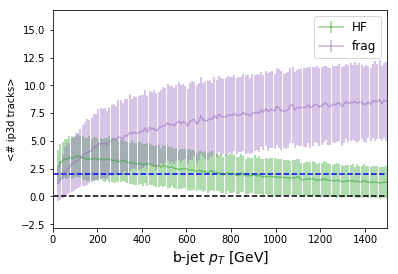

In [13]:
plt.errorbar(mid_pt,mu_HF,sd_HF,label='HF',color='C2',alpha=0.5)
plt.errorbar(mid_pt,mu_frag,sd_frag,label='frag',color='C4',alpha=0.5)

plt.plot([0,1500],[0,0],'k--')
plt.plot([0,1500],[2,2],'b--')

plt.xlim(0,1500)
plt.xlabel('b-jet $p_T$ [GeV]', fontsize = 14)
plt.ylabel('<# ip3d tracks>')
plt.legend(fontsize=12)

plt.show()

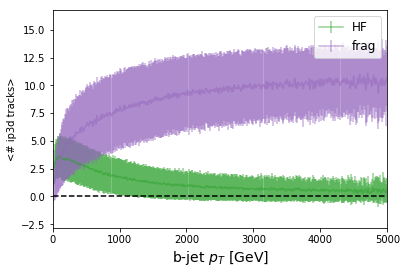

In [14]:
plt.errorbar(mid_pt,mu_HF,sd_HF,label='HF',color='C2',alpha=0.5)
plt.errorbar(mid_pt,mu_frag,sd_frag,label='frag',color='C4',alpha=0.5)

plt.plot([0,5000],[0,0],'k--')

plt.xlim(0,5000)
plt.xlabel('b-jet $p_T$ [GeV]', fontsize = 14)
plt.ylabel('<# ip3d tracks>')
plt.legend(fontsize=12)

plt.savefig('{}/mc16d_PFlow_Zprime_5TeV/nTrks_HF_frag.pdf'.format(figDir))

plt.show()

One more thing that worried me about this plot was that I might be missing HF tracks with large negative $s_{d0}$s due to resolution effects.  To see if this actually is hurting me, I think I should plot $n_{trk}^{IP3D}$ to see what effect this truncating to 15 tracks is having.

I'm a little bit upset at myself. I actally can't make this plot because I didn't save jet_ip3d_ntrk to the jet_df.

In [14]:
nBins = 26
myRange = (-0.5,25.5)

#for physicsSample, c, label in zip(['ttbar','Zprime_1.5TeV','Zprime_5TeV'],
#                                   ['C2','C4','C6'],[r't\bar{t}','Z\' 1.5 TeV','Z\' 5 TeV']):
    
#    # Open the df
#    subDir = 'mc16d_PFlow_'+physicsSample
#    tmp_df = pd.read_hdf('../../data/{}/jet_{}.h5'.format(subDir,df_tag), key='jet_df')
    
    # Draw the histogram
#    plt.hist(tmp_df[''], bins=nBins, range=myRange,
#             label=orig_tag, color=c, histtype='step')

# Add labels and legends
#plt.xlim(myRange)
#plt.xlabel('$n_{trk}^{IP3D}$',fontsize=16)
#plt.legend()

#plt.show()


Also, for presentations, include the extended Z' $p_T$ spectrum.

In [34]:
text="$\mathbf{ATLAS}$ Simulation Internal\n"
text+="mc16d PFlow Z' 5 TeV sample"

for flav,pdg in zip(['l','c','b'],[0,4,5]):
    
    plt.hist(jet_df.loc[jet_df.LabDr_HadF==pdg,'pt'],label='{} jets'.format(flav),
             bins=150,range=(0,6500),
             histtype='step',log=True)
    
plt.xlabel('jet $p_T$ [GeV]',fontsize=14)
plt.legend()

ymax = 5e5
plt.ylim(.1,ymax)
plt.text(0,ymax,text,horizontalalignment='left', verticalalignment='bottom')
plt.savefig('{}/mc16d_PFlow_Zprime_5TeV/jet_pT.pdf'.format(figDir,subDir))

plt.show()

**Motivation part 2:** Evaluate the **standard** hybrid training on the extended Z' sample to make sure that I still have discrimination power as far out as I had the training events. Binbin previously trained on this extended hybrid sample, so I'm using [her talk](https://indico.cern.ch/event/783073/contributions/3282556/attachments/1780573/2896568/ExtendedZprime_19.01.17.pdf) to help guide me with respect to what plots I should be making


*How can I tell how far out I have discrimination power?*

If I plot $D_b$ as a function of jet $p_T$ for each of the jet flavors, when the discriminant becomes indistinguishable, I've lost discrimination power, and this is where I would expect to gain by retraining.

In [15]:
# Load in the hybrid model

modelDir = "../../models/mc16d_PFlow_hybrid_1.5TeV"
nHidden=200
dataTagTrain = "5mtrain_15trks_{}_sd0_rev".format(vStr)
m = myLSTM(modelDir=modelDir, nFeatures=nFeatures, nHidden=nHidden, dataTag=dataTagTrain, loadModel=True)


Initialize method from myModel()
Loading previously trained LSTM


In [16]:
# Get the discriminant
tag = '_eval_Zprime_5TeV'
(leff, ceff, beff), d = getEffs(m, X, y, ix, returnDisc=True, figDir=figDir, subDir=subDir, 
                                  modelDir=modelDir,tag=tag)

Load in the previously saved efficiency file


What $D_b$ should you expect when the model has lost discrimination?

Since at high $p_T$ this sample doesn't have any $\tau$s, the output nodes will probably be $p_l = p_c = p_b = 1/3$, so $D_b \approx \ln 1 = 0$.

In [17]:
for yi, flav in enumerate(['l','c','b']):

    mu_Db = np.array([d[(indices==i)&(y==yi)].mean() for i in range(1,pT_edges.shape[0])])
    sd_Db = np.array([d[(indices==i)&(y==yi)].std()  for i in range(1,pT_edges.shape[0])])

    plt.errorbar(mid_pt, mu_Db, sd_Db, label=flav+'-jets', alpha=0.4)

    
plt.plot([0,5000],[0,0],'k--')
plt.xlim(0,5000)
plt.xlabel('jet $p_T$ [GeV]', fontsize=14)
plt.ylabel('$D_b$',fontsize=14)
plt.title('Standard hybrid training')
plt.legend(fontsize=12)

plt.savefig('{}/mc16d_PFlow_Zprime_5TeV/disc_vs_jpt_std_hybrid.pdf'.format(figDir))

plt.show()


/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice.
  This is separate from the ipykernel package so we can avoid doing imports until
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered 

Ok, so what I think this plot is telling me is that even with this standard hybrid training, I should see some discrimination power, even out to 5 TeV. The question is: *Can I improve on this with a dedicated extended hybrid training?*

## Evaluate all of the models on the relevant training sets

The idea is, to evaluate the extended hybrid training, I want to ensure that I have as good (or at least compatible) performance for the standard and dedicated sample trainings.


Evaluating on ttbar
Initialize method from myModel()
Loading previously trained LSTM
acc
loss
val_acc
val_loss


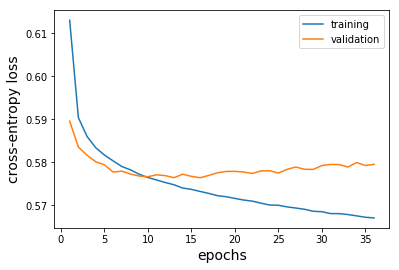

Load in the previously saved efficiency file
Initialize method from myModel()
Loading previously trained LSTM
acc
loss
val_acc
val_loss


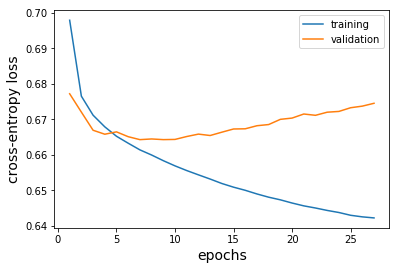

Load in the previously saved efficiency file
Initialize method from myModel()
Loading previously trained LSTM
acc
loss
val_acc
val_loss


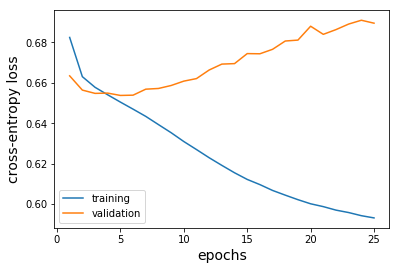

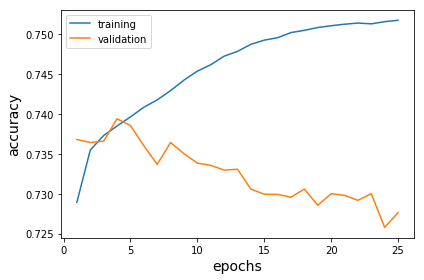

Load in the previously saved efficiency file
Initialize method from myModel()
Loading previously trained LSTM
acc
loss
val_acc
val_loss


Load in the previously saved efficiency file
Initialize method from myModel()
Loading previously trained LSTM
acc
loss
val_acc
val_loss


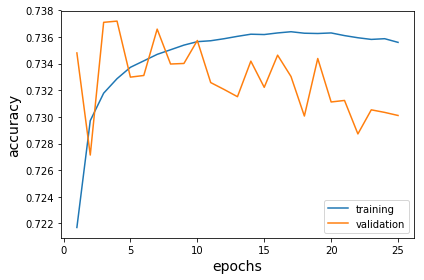

Load in the previously saved efficiency file
Evaluating on Zprime_1.5TeV
Initialize method from myModel()
Loading previously trained LSTM
Load in the previously saved efficiency file
Initialize method from myModel()
Loading previously trained LSTM
Load in the previously saved efficiency file
Initialize method from myModel()
Loading previously trained LSTM
Load in the previously saved efficiency file
Initialize method from myModel()
Loading previously trained LSTM
Load in the previously saved efficiency file
Initialize method from myModel()
Loading previously trained LSTM
Load in the previously saved efficiency file
Evaluating on Zprime_5TeV
Initialize method from myModel()
Loading previously trained LSTM
Load in the previously saved efficiency file
Initialize method from myModel()
Loading previously trained LSTM
Load in the previously saved efficiency file
Initialize method from myModel()
Loading previously trained LSTM
Load in the previously saved efficiency file
Initialize method fro

In [18]:
leffs, ceffs, beffs, = [],[],[]
discs, labels = [],[]
ys, pts, etas = [],[],[]

for physicsSample, Ntest in zip(['ttbar','Zprime_1.5TeV','Zprime_5TeV'],[int(Ntest)]*3):
        
    print('Evaluating on '+physicsSample)
        
    for trainPhysicsSample, Ntrain, nHidden in zip(['ttbar','hybrid_1.5TeV','hybrid_5TeV','Zprime_1.5TeV','Zprime_5TeV'],
                                                   [int(3e6),int(5e6),int(5e6),int(5e6),int(5e6)],
                                                   [100,200,400,200,200]):
        
        # Load in the sample for evaluation
        subDir = 'mc16d_PFlow_'+physicsSample
        dataDir = '../../data/'+subDir
        scale_tag = "_{}_scale".format(trainPhysicsSample) if physicsSample != trainPhysicsSample else ""
        dataTagTest = "2mtest_15trks_{}_sd0_rev{}".format(vStr, scale_tag)

        f_name = "{}/data_{}.hdf5".format(dataDir,dataTagTest)
        f = h5py.File(f_name,"r")
    
        X = f['X_test'][:]
        y = f['y_test'][:]
        ix = f['ix_test'][:]
    
        f.close()
        
        # Also open the df so that you'll have access to the jet pt and eta
        jet_df = pd.read_hdf('{}/jet_{}.h5'.format(dataDir,df_tag), key='jet_df')
        
        # Load in the model
        modelDir = "../../models/mc16d_PFlow_"+trainPhysicsSample
        dataTagTrain = "{}train_15trks_{}_sd0_rev".format(nJetsTag(Ntrain),vStr)
        m = myLSTM(modelDir=modelDir, nFeatures=nFeatures, nHidden=nHidden, dataTag=dataTagTrain, loadModel=True)

        # Training metrics
        if physicsSample == 'ttbar':
            trainingMetrics(m.modelName,modelDir=modelDir)
        
        # Get the efficiencies
        tag = '_eval_{}'.format(physicsSample) if physicsSample != trainPhysicsSample else ''
        (leff, ceff, beff), d = getEffs(m, X, y, ix, returnDisc=True,
                                        figDir=figDir,subDir=subDir,modelDir=modelDir,tag=tag)

        leffs.append(leff)
        ceffs.append(ceff)
        beffs.append(beff)
        
        discs.append(d)
        labels.append('train {}, eval {}'.format(trainPhysicsSample,physicsSample))
        
        ys.append(y)
        pts.append(jet_df.pt.values)
        etas.append(jet_df.eta.values)

### $t\bar{t}$

../../plottingFcts.py:595: RuntimeWarning: invalid value encountered in sqrt
  eff_err = lambda x, N: np.sqrt( x*(1-x) / N)
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/scipy/interpolate/_cubic.py:147: RuntimeWarning: divide by zero encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/scipy/interpolate/_cubic.py:165: RuntimeWarning: invalid value encountered in true_divide
  whmean = (w1/mk[:-1] + w2/mk[1:]) / (w1 + w2)
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/scipy/interpolate/_cubic.py:117: RuntimeWarning: invalid value encountered in multiply
  d = ((2*h0 + h1)*m0 - h0*m1) / (h0 + h1)
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/scipy/interpolate/_cubic.py:147: RuntimeWarning: invalid value encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk


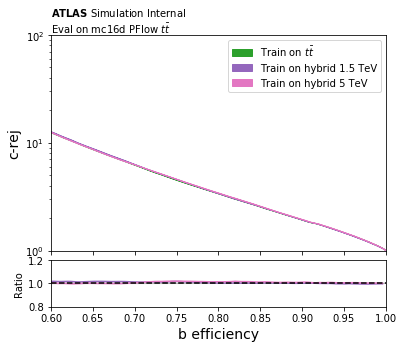

In [19]:
train_labels=['Train on {}'.format(x) for x in [r'$t\bar{t}$','hybrid 1.5 TeV','hybrid 5 TeV','Z\' 1.5 TeV','Z\' 5 TeV']]
subDir = 'mc16d_PFlow_ttbar'
plotTag1 = 'rej_cf_ext_hyb'
plotTag2 = plotTag1+'_Zprime'

text="$\mathbf{ATLAS}$ Simulation Internal\n"
text+=r"Eval on mc16d PFlow $t\bar{t}$"

colors = ['C2','C4','C6','C0','C1']

plotROCRatio(beffs[:3], leffs[:3], train_labels[:3], rrange=(0.8,1.2),ymax=1000,
             text=text,ylabel='l-rej',binomialErrors=True,nTest=Ntest, 
             colors=colors, figDir=figDir,subDir=subDir,tag='l'+plotTag1)

plotROCRatio(beffs[:3], ceffs[:3], train_labels[:3], rrange=(0.8,1.2),ymax=100,
             text=text,ylabel='c-rej',binomialErrors=True,nTest=Ntest, 
             colors=colors, figDir=figDir,subDir=subDir,tag='c'+plotTag1)

../../plottingFcts.py:595: RuntimeWarning: invalid value encountered in sqrt
  eff_err = lambda x, N: np.sqrt( x*(1-x) / N)
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/scipy/interpolate/_cubic.py:147: RuntimeWarning: divide by zero encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/scipy/interpolate/_cubic.py:165: RuntimeWarning: invalid value encountered in true_divide
  whmean = (w1/mk[:-1] + w2/mk[1:]) / (w1 + w2)
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/scipy/interpolate/_cubic.py:117: RuntimeWarning: invalid value encountered in multiply
  d = ((2*h0 + h1)*m0 - h0*m1) / (h0 + h1)
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/scipy/interpolate/_cubic.py:147: RuntimeWarning: invalid value encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk


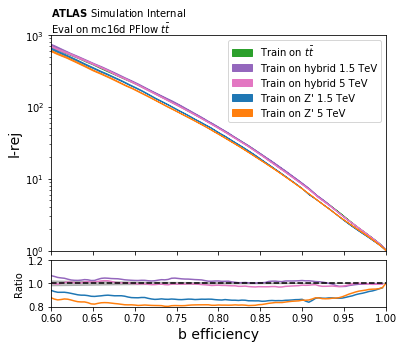

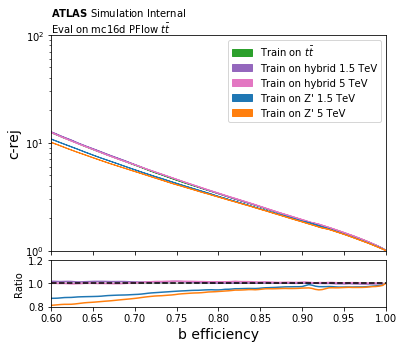

In [20]:
plotROCRatio(beffs[:5], leffs[:5], train_labels, rrange=(0.8,1.2),ymax=1000,
             text=text,ylabel='l-rej',binomialErrors=True,nTest=Ntest, 
             colors=colors, figDir=figDir,subDir=subDir,tag='l'+plotTag2)

plotROCRatio(beffs[:5], ceffs[:5], train_labels, rrange=(0.8,1.2),ymax=100,
             text=text,ylabel='c-rej',binomialErrors=True,nTest=Ntest, 
             colors=colors, figDir=figDir,subDir=subDir,tag='c'+plotTag2)

When evaluating on $t\bar{t}$, there's some loss in performance for l-rej with the extended hybrid training, so I think I just need to increase the complexity of this extended model.

**Comparison with previous work** Francesco sent me some studies that he had done before where he showed that the c-rej on $t\bar{t}$ was quite a bit worse when he trained on Z', and it's clear that I'm seeing this effect as well. Further more, the degradation in performance is worse when we're looking at training on the extended Z' as opposed to just the Z' sample.

<img src="../../figures/crej_Zprime_train_Francesco.png" width="400">


This was interesting to me because the plots that I showed at [P&P week](https://indico.cern.ch/event/787930/contributions/3280581/attachments/1781904/2901443/Hartman_Jan_22_19.pdf) had better charm performance over all the $p_T$ bins for the hybrid training than the dedicated $t\bar{t}$ training when evaluating the charm rejection on $t\bar{t}$.

I wasn't sure if this was because the democratic decay of the Z' meant training on the hybrid caused us to do better at classifying cs. But since I don't do as well on $t\bar{t}$ c-rej for the dedicated Z' training, this is not the reason. 

So the reason why my hybrid model was outperforming the $t\bar{t}$ was just because I was using a more complex hybrid model.


#### $p_T$ and $\eta$ dependence

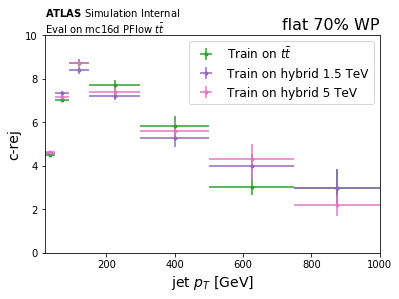

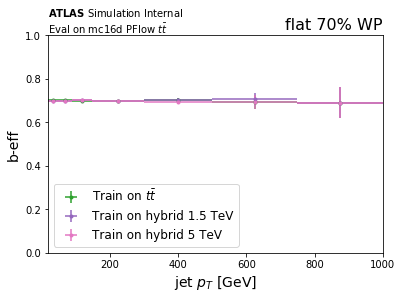

In [24]:
tag1 = 'cf_ext_hyb'
tag2 = tag1+'_Zprime'

plotPtDependence(pts[0],ys[0],discs[:3], train_labels[:3],
                 lrej_lim=(0,500),crej_lim=(0,10),beff_lim=(0,1),
                 flat=True,binomialErrors=True,colors=colors,text=text,
                 pt_edges=np.array([20, 50, 90, 150, 300, 500, 750, 1000]),
                 eff_bins = np.array([20,30,40,50,70,90,120,150,200,250,300,350,400,450,500,550,600,675,750,875,950,1000]),
                 figDir=figDir,subDir=subDir,tag=tag1,verbose=False)

/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/matplotlib/pyplot.py:1479: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ret = ax.set_ylim(*args, **kwargs)


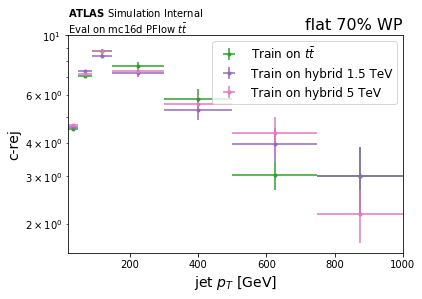

In [25]:
plotPtDependence(pts[0],ys[0],discs[:3], train_labels[:3],
                 lrej_lim=(0,500),crej_lim=(0,10),beff_lim=(0,1),
                 flat=True,binomialErrors=True,colors=colors,text=text,
                 pt_edges=np.array([20, 50, 90, 150, 300, 500, 750, 1000]),
                 eff_bins = np.array([20,30,40,50,70,90,120,150,200,250,300,350,400,450,500,550,600,675,750,875,950,1000]),
                 figDir=figDir,subDir=subDir,tag=tag1,verbose=False, log=True)

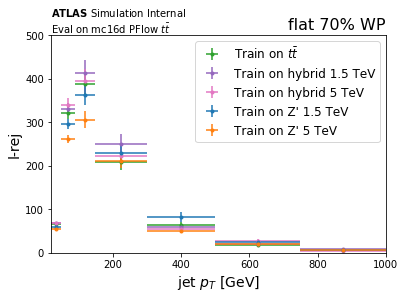

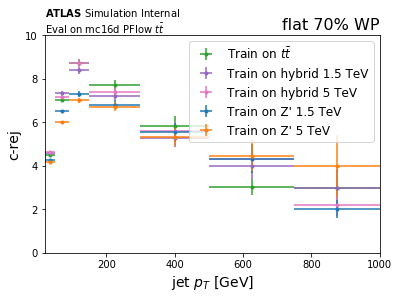

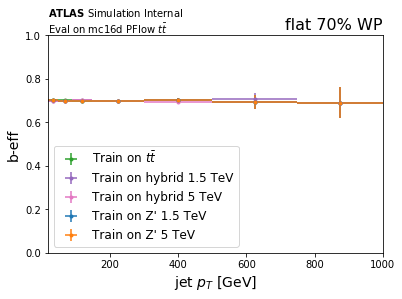

In [24]:
plotPtDependence(pts[0],ys[0],discs[:5], train_labels,
                 lrej_lim=(0,500),crej_lim=(0,10),beff_lim=(0,1),
                 flat=True,binomialErrors=True,colors=colors,text=text,
                 pt_edges=np.array([20, 50, 90, 150, 300, 500, 750, 1000]),
                 eff_bins = np.array([20,30,40,50,70,90,120,150,200,250,300,350,400,450,500,550,600,675,750,875,950,1000]),
                 figDir=figDir,subDir=subDir,tag=tag2,verbose=False)

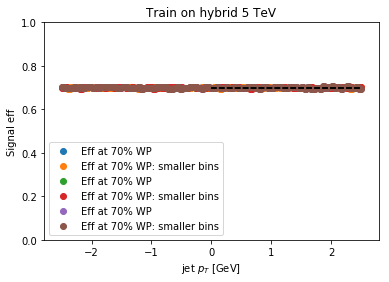

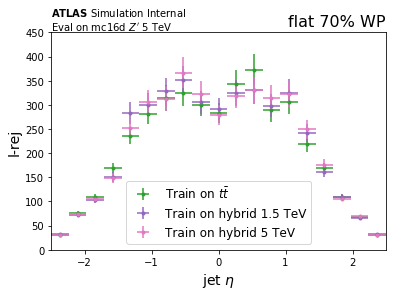

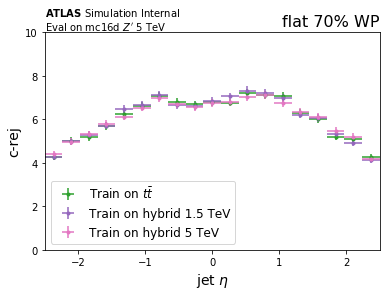

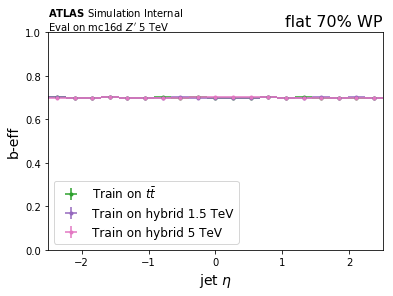

In [46]:
eta_min = -2.5
eta_max =  2.5

plotPtDependence(etas[0],ys[0],discs[:3], train_labels[:3], xlabel='jet $\eta$',
                 lrej_lim=(0,450),crej_lim=(0,10),beff_lim=(0,1),
                 flat=True,binomialErrors=True,colors=colors,text=text,
                 pt_edges=np.linspace(eta_min,eta_max,20),
                 eff_bins = np.linspace(eta_min,eta_max,100),
                 figDir=figDir,subDir=subDir,tag=tag1,
                 var='eta',verbose=False)

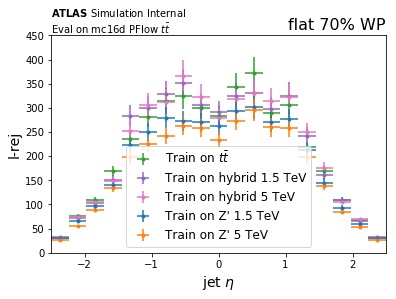

In [26]:
plotPtDependence(etas[0],ys[0],discs[:5], train_labels,xlabel='jet $\eta$',
                 lrej_lim=(0,450),crej_lim=(0,10),beff_lim=(0,1),
                 flat=True,binomialErrors=True,colors=colors,text=text,
                 pt_edges=np.linspace(eta_min,eta_max,20),
                 eff_bins = np.linspace(eta_min,eta_max,100),
                 figDir=figDir,subDir=subDir,tag=tag2,
                 var='eta',verbose=False)

### Z': 1.5 TeV

In [49]:
subDir = 'mc16d_PFlow_Zprime_1.5TeV'

text="$\mathbf{ATLAS}$ Simulation Internal\n"
text+=r"Eval on mc16d $Z'$ 1.5 TeV"

plotROCRatio(beffs[5:8], leffs[5:8], train_labels[:3], rrange=(0.9,2.5),ymax=100,
             text=text,ylabel='l-rej',binomialErrors=True,nTest=Ntest, 
             colors=colors, figDir=figDir,subDir=subDir,tag='l'+plotTag1)

plotROCRatio(beffs[5:8], ceffs[5:8], train_labels[:3], rrange=(0.9,1.25),ymax=10,
             text=text,ylabel='c-rej',binomialErrors=True,nTest=Ntest, 
             colors=colors, figDir=figDir,subDir=subDir,tag='c'+plotTag1)

../../plottingFcts.py:595: RuntimeWarning: invalid value encountered in sqrt
  eff_err = lambda x, N: np.sqrt( x*(1-x) / N)
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/scipy/interpolate/_cubic.py:147: RuntimeWarning: divide by zero encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/scipy/interpolate/_cubic.py:147: RuntimeWarning: invalid value encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/scipy/interpolate/_cubic.py:165: RuntimeWarning: invalid value encountered in true_divide
  whmean = (w1/mk[:-1] + w2/mk[1:]) / (w1 + w2)
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/scipy/interpolate/_cubic.py:117: RuntimeWarning: invalid value encountered in multiply
  d = ((2*h0 + h1)*m0 - h0*m1) / (h0 + h1)


../../plottingFcts.py:595: RuntimeWarning: invalid value encountered in sqrt
  eff_err = lambda x, N: np.sqrt( x*(1-x) / N)
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/scipy/interpolate/_cubic.py:147: RuntimeWarning: divide by zero encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/scipy/interpolate/_cubic.py:147: RuntimeWarning: invalid value encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/scipy/interpolate/_cubic.py:165: RuntimeWarning: invalid value encountered in true_divide
  whmean = (w1/mk[:-1] + w2/mk[1:]) / (w1 + w2)
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/scipy/interpolate/_cubic.py:117: RuntimeWarning: invalid value encountered in multiply
  d = ((2*h0 + h1)*m0 - h0*m1) / (h0 + h1)


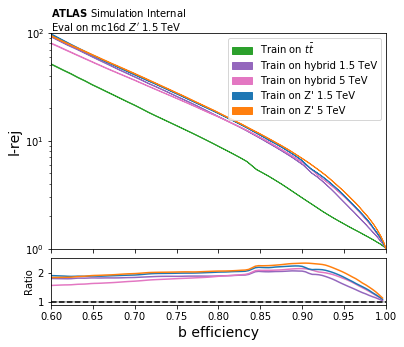

In [27]:
plotROCRatio(beffs[5:10], leffs[5:10], train_labels, rrange=(0.9,2.5),ymax=100,
             text=text,ylabel='l-rej',binomialErrors=True,nTest=Ntest, 
             colors=colors, figDir=figDir,subDir=subDir,tag='l'+plotTag2)

plotROCRatio(beffs[5:10], ceffs[5:10], train_labels, rrange=(0.9,1.25),ymax=10,
             text=text,ylabel='c-rej',binomialErrors=True,nTest=Ntest, 
             colors=colors, figDir=figDir,subDir=subDir,tag='c'+plotTag2)

#### $p_T$ and $\eta$ dependence

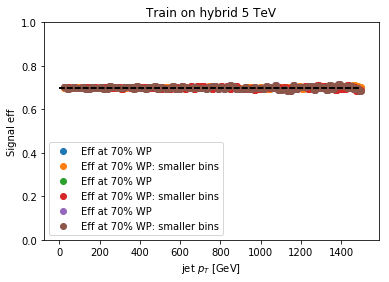

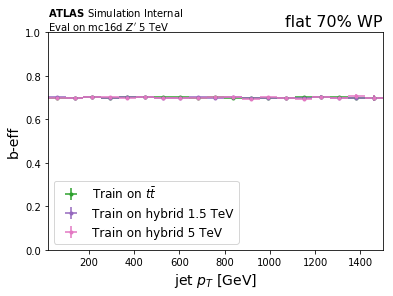

In [42]:
ptmin = 20
ptmax = 1500

plotPtDependence(pts[5],ys[5],discs[5:8],train_labels[:3],
                 lrej_lim=(0,250),crej_lim=(0,10),beff_lim=(0,1),
                 flat=True,binomialErrors=True,colors=colors,text=text,
                 pt_edges=np.linspace(ptmin,ptmax,20),
                 eff_bins = np.linspace(ptmin,ptmax,100),
                 figDir=figDir,subDir=subDir,tag=tag1,verbose=False)

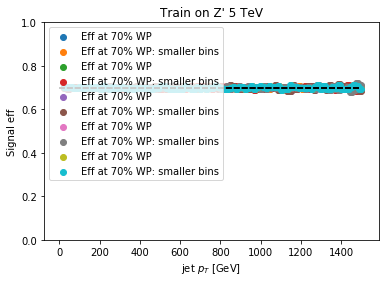

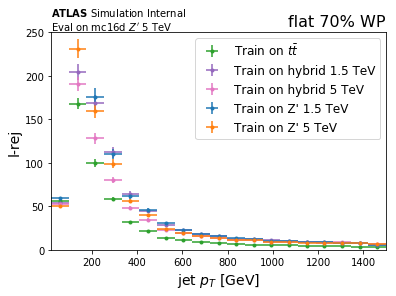

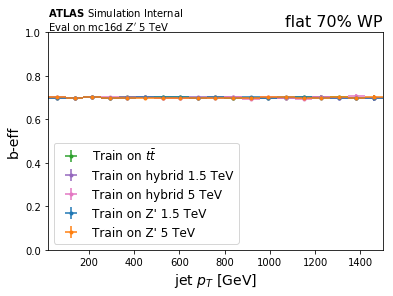

In [43]:
plotPtDependence(pts[5],ys[5],discs[5:10],train_labels,
                 lrej_lim=(0,250),crej_lim=(0,10),beff_lim=(0,1),
                 flat=True,binomialErrors=True,colors=colors,text=text,
                 pt_edges=np.linspace(ptmin,ptmax,20),
                 eff_bins = np.linspace(ptmin,ptmax,100),
                 figDir=figDir,subDir=subDir,tag=tag2,verbose=False)

/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/matplotlib/pyplot.py:1479: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ret = ax.set_ylim(*args, **kwargs)


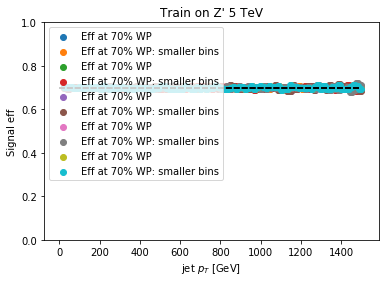

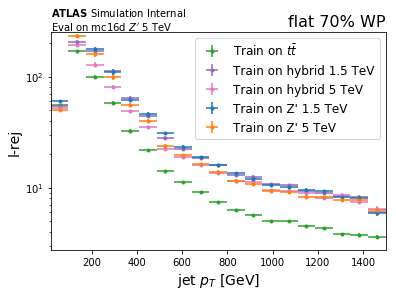

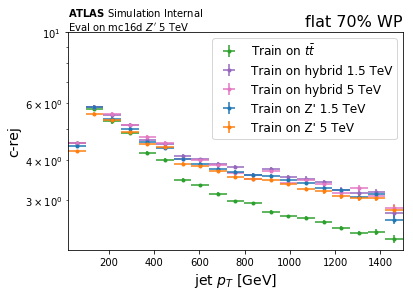

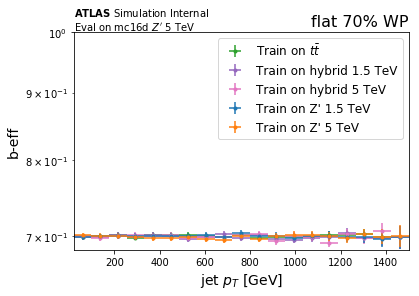

In [44]:
plotPtDependence(pts[5],ys[5],discs[5:10],train_labels,
                 lrej_lim=(0,250),crej_lim=(0,10),beff_lim=(0,1),
                 flat=True,binomialErrors=True,colors=colors,text=text,
                 pt_edges=np.linspace(ptmin,ptmax,20),
                 eff_bins = np.linspace(ptmin,ptmax,100),
                 figDir=figDir,subDir=subDir,tag=tag2,verbose=False,log=True)

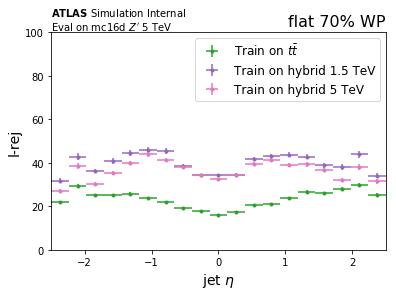

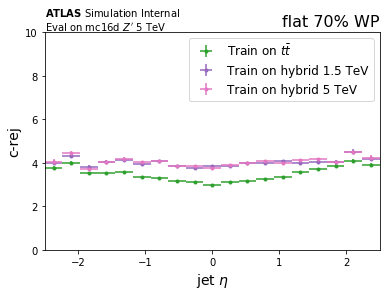

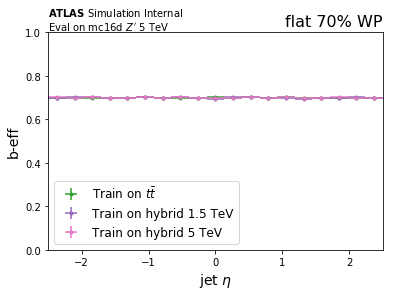

In [47]:
plotPtDependence(etas[5],ys[5],discs[5:8], train_labels[:3],xlabel='jet $\eta$',
                 lrej_lim=(0,100),crej_lim=(0,10),beff_lim=(0,1),
                 flat=True,binomialErrors=True,colors=colors,text=text,
                 pt_edges=np.linspace(eta_min,eta_max,20),
                 eff_bins = np.linspace(eta_min,eta_max,100),
                 figDir=figDir,subDir=subDir,tag=tag1,var='eta',verbose=False)

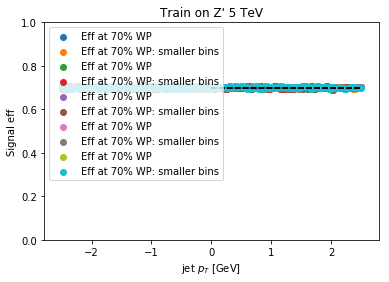

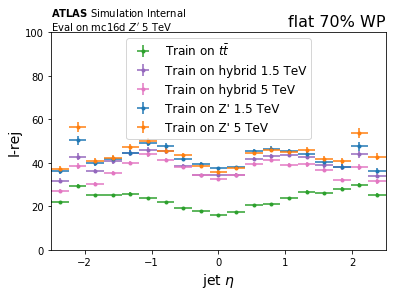

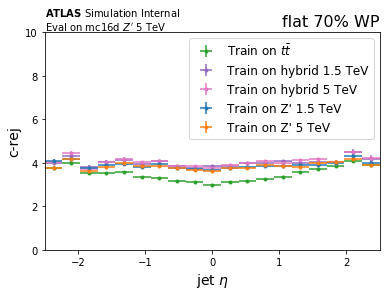

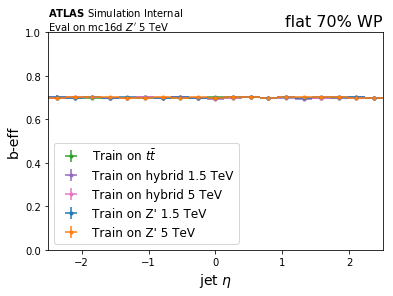

In [48]:
plotPtDependence(etas[5],ys[5],discs[5:10], train_labels,xlabel='jet $\eta$',
                 lrej_lim=(0,100),crej_lim=(0,10),beff_lim=(0,1),
                 flat=True,binomialErrors=True,colors=colors,text=text,
                 pt_edges=np.linspace(eta_min,eta_max,20),
                 eff_bins = np.linspace(eta_min,eta_max,100),
                 figDir=figDir,subDir=subDir,tag=tag2,var='eta',verbose=False)

### Z': 5 TeV

../../plottingFcts.py:595: RuntimeWarning: invalid value encountered in sqrt
  eff_err = lambda x, N: np.sqrt( x*(1-x) / N)
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/scipy/interpolate/_cubic.py:147: RuntimeWarning: divide by zero encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/scipy/interpolate/_cubic.py:147: RuntimeWarning: invalid value encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/scipy/interpolate/_cubic.py:165: RuntimeWarning: invalid value encountered in true_divide
  whmean = (w1/mk[:-1] + w2/mk[1:]) / (w1 + w2)
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/scipy/interpolate/_cubic.py:117: RuntimeWarning: invalid value encountered in multiply
  d = ((2*h0 + h1)*m0 - h0*m1) / (h0 + h1)


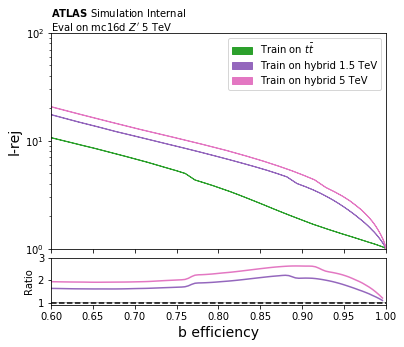

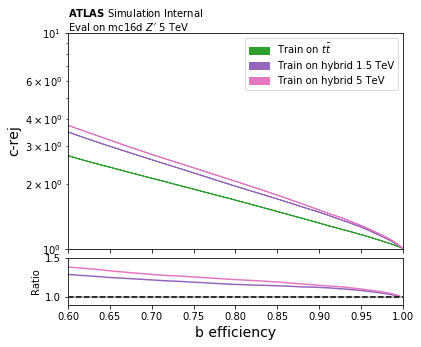

In [50]:
subDir = 'mc16d_PFlow_Zprime_5TeV'

text="$\mathbf{ATLAS}$ Simulation Internal\n"
text+=r"Eval on mc16d $Z'$ 5 TeV"

plotROCRatio(beffs[10:13], leffs[10:13], train_labels[:3], rrange=(0.9,3),ymax=100,
             text=text,ylabel='l-rej',binomialErrors=True,nTest=Ntest, 
             colors=colors, figDir=figDir,subDir=subDir,tag='l'+plotTag1)

plotROCRatio(beffs[10:13], ceffs[10:13], train_labels, rrange=(0.9,1.5),ymax=10,
             text=text,ylabel='c-rej',binomialErrors=True,nTest=Ntest, 
             colors=colors, figDir=figDir,subDir=subDir,tag='c'+plotTag1)

../../plottingFcts.py:595: RuntimeWarning: invalid value encountered in sqrt
  eff_err = lambda x, N: np.sqrt( x*(1-x) / N)
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/scipy/interpolate/_cubic.py:147: RuntimeWarning: divide by zero encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/scipy/interpolate/_cubic.py:147: RuntimeWarning: invalid value encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/scipy/interpolate/_cubic.py:165: RuntimeWarning: invalid value encountered in true_divide
  whmean = (w1/mk[:-1] + w2/mk[1:]) / (w1 + w2)
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/scipy/interpolate/_cubic.py:117: RuntimeWarning: invalid value encountered in multiply
  d = ((2*h0 + h1)*m0 - h0*m1) / (h0 + h1)


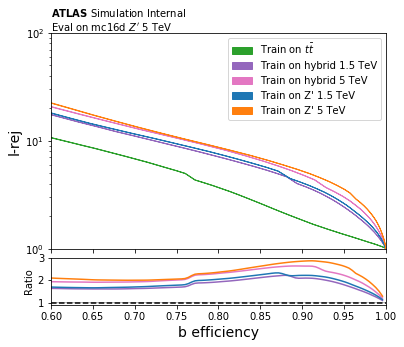

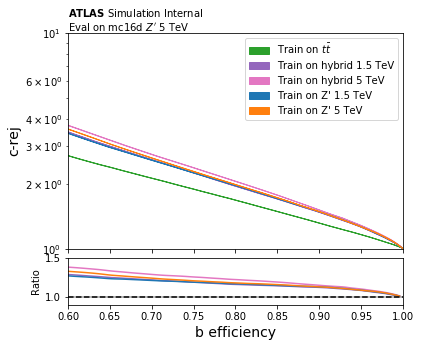

In [51]:
plotROCRatio(beffs[10:], leffs[10:], train_labels, rrange=(0.9,3),ymax=100,
             text=text,ylabel='l-rej',binomialErrors=True,nTest=Ntest, 
             colors=colors, figDir=figDir,subDir=subDir,tag='l'+plotTag2)

plotROCRatio(beffs[10:], ceffs[10:], train_labels, rrange=(0.9,1.5),ymax=10,
             text=text,ylabel='c-rej',binomialErrors=True,nTest=Ntest, 
             colors=colors, figDir=figDir,subDir=subDir,tag='c'+plotTag2)

#### $p_T$ and $\eta$ dependence

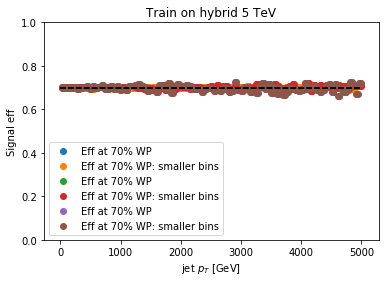

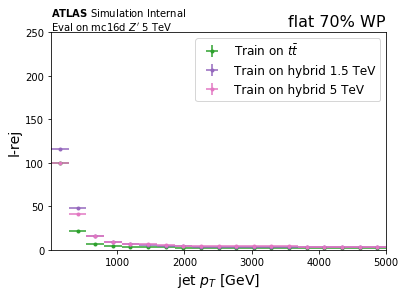

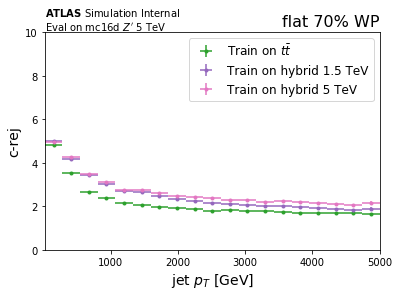

In [52]:
ptmax=5000
plotPtDependence(pts[10],ys[10],discs[10:13],train_labels[:3],
                 lrej_lim=(0,250),crej_lim=(0,10),beff_lim=(0,1),
                 flat=True,binomialErrors=True,colors=colors,text=text,
                 pt_edges=np.linspace(ptmin,ptmax,20),
                 eff_bins = np.linspace(ptmin,ptmax,100),
                 figDir=figDir,subDir=subDir,tag=tag1,verbose=False)

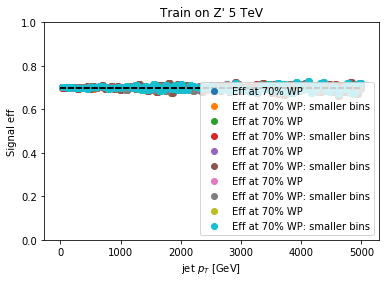

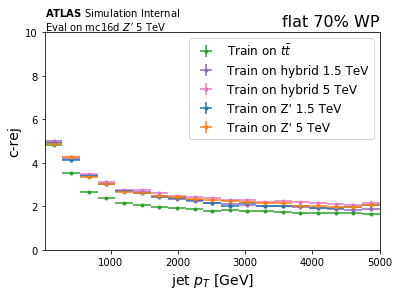

In [53]:
plotPtDependence(pts[10],ys[10],discs[10:],train_labels,
                 lrej_lim=(0,250),crej_lim=(0,10),beff_lim=(0,1),
                 flat=True,binomialErrors=True,colors=colors,text=text,
                 pt_edges=np.linspace(ptmin,ptmax,20),
                 eff_bins = np.linspace(ptmin,ptmax,100),
                 figDir=figDir,subDir=subDir,tag=tag2,verbose=False)

/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/matplotlib/pyplot.py:1479: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ret = ax.set_ylim(*args, **kwargs)


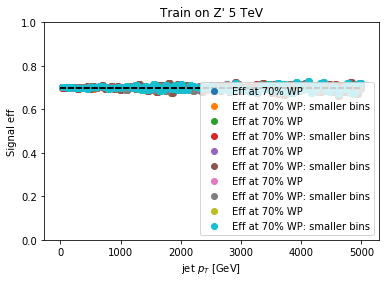

In [54]:
plotPtDependence(pts[10],ys[10],discs[10:],train_labels,
                 lrej_lim=(0,250),crej_lim=(0,10),beff_lim=(0,1),
                 flat=True,binomialErrors=True,colors=colors,text=text,
                 pt_edges=np.linspace(ptmin,ptmax,20),
                 eff_bins = np.linspace(ptmin,ptmax,100),
                 figDir=figDir,subDir=subDir,tag=tag2,verbose=False,log=True)

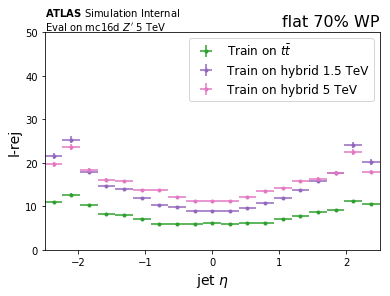

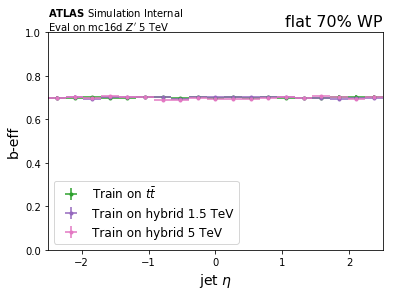

In [55]:
plotPtDependence(etas[10],ys[10],discs[10:13],train_labels[:3],xlabel='jet $\eta$',
                 lrej_lim=(0,50),crej_lim=(0,10),beff_lim=(0,1),
                 flat=True,binomialErrors=True,colors=colors,text=text,
                 pt_edges=np.linspace(eta_min,eta_max,20),
                 eff_bins = np.linspace(eta_min,eta_max,100),
                 figDir=figDir,subDir=subDir,tag=tag1,var='eta',verbose=False)

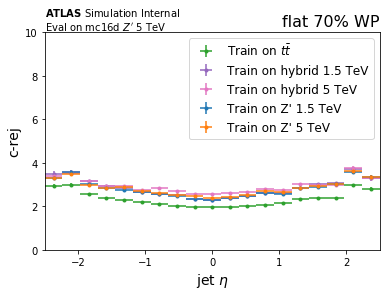

In [56]:
plotPtDependence(etas[10],ys[10],discs[10:],train_labels,xlabel='jet $\eta$',
                 lrej_lim=(0,50),crej_lim=(0,10),beff_lim=(0,1),
                 flat=True,binomialErrors=True,colors=colors,text=text,
                 pt_edges=np.linspace(eta_min,eta_max,20),
                 eff_bins = np.linspace(eta_min,eta_max,100),
                 figDir=figDir,subDir=subDir,tag=tag1,var='eta',verbose=False)

Just for fun... look at how the discriminant evolves as a function of the jet $p_T$ when you use the extended hybrid training!

In [57]:
d = discs[-3]

for yi, flav in enumerate(['l','c','b']):

    mu_Db = np.array([d[(indices==i)&(y==yi)].mean() for i in range(1,pT_edges.shape[0])])
    sd_Db = np.array([d[(indices==i)&(y==yi)].std()  for i in range(1,pT_edges.shape[0])])

    plt.errorbar(mid_pt, mu_Db, sd_Db, label=flav+'-jets', alpha=0.4)

    
plt.plot([0,5000],[0,0],'k--')
plt.xlim(0,5000)
plt.xlabel('jet $p_T$ [GeV]', fontsize=14)
plt.ylabel('$D_b$',fontsize=14)
plt.title('Extended hybrid training')
plt.legend(fontsize=12)

plt.savefig('{}/mc16d_PFlow_Zprime_5TeV/disc_vs_jpt_ext_hybrid.pdf'.format(figDir))

plt.show()

/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice.
  """
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
